**<h1>GLASSES OR NO GLASSES</h1>**

The aim of this work is to determine if a person is wearing glasses or not, in a supervised way, using neural networks.
The data is available on [www.kaggle.com/jeffheaton/glasses-or-no-glasses](https://) , where there are two datasets of the same 5000 samples provided in two different configurations:
* samples made up of 512 numerical features (and binary labels), which we will use to train Multi-Layer Perceptrons;
* 1024x1024 color images, which we will use to train CNNs.
---
Firstly, download the data using the Kaggle API. To do so, we replace `KAGGLE_USERNAME` and `KAGGLE_KEY` variables with our Kaggle credentials. Then, we unzip them.

In [ ]:
import os
os.environ['KAGGLE_USERNAME'] = "xxxxxxxxxx"                     
os.environ['KAGGLE_KEY'] = "xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx"

if not os.path.exists("/content/glasses-or-no-glasses.zip"):
  !kaggle datasets download -d jeffheaton/glasses-or-no-glasses

if not os.path.exists("/content/faces-spring-2020"):
  !unzip -o -q /content/glasses-or-no-glasses.zip

100% 6.11G/6.11G [02:20<00:00, 69.4MB/s]
100% 6.11G/6.11G [02:20<00:00, 46.8MB/s]


Next, we set all the *seed* variables, in order to allow reproducibility of our experiments.

In [ ]:
random_state = 0

os.environ["PYTHONHASHSEED"] = str(random_state)

import random
random.seed(random_state)

import numpy as np
np.random.seed(random_state)

import tensorflow as tf
tf.random.set_seed(random_state)

**<h2>Numerical Dataset</h2>**
<h2>Importing the data</h2>

Training and Test Set are provided separately in two different `.csv` files. As we have already downloaded and unzipped them, we can easily import them as `pandas.DataFrame`. After that, we prefer to merge them, preprocess data and then create our personal splits in a second moment.

In [ ]:
import pandas as pd
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

df = pd.concat([train_df, test_df], ignore_index=True)
df

id       v1       v2       v3  ...     v510     v511     v512  glasses
0        1  0.37797 -0.94808  0.01346  ...  1.08635  1.69027  0.61609      0.0
1        2  0.07609 -0.09774  0.39666  ...  0.00866 -1.27640 -0.60496      1.0
2        3  1.19391 -0.68707 -0.68422  ... -0.60177  0.43555  0.41982      1.0
3        4  1.34949 -0.31498 -1.30248  ...  0.83997 -0.46986  0.06755      0.0
4        5 -0.03512 -0.34196  0.14230  ...  0.83641  0.59756 -0.20298      0.0
...    ...      ...      ...      ...  ...      ...      ...      ...      ...
4995  4996  0.07877 -0.47999  0.26438  ... -0.43146  0.26931 -0.84718      NaN
4996  4997  1.93614  0.55157 -1.50441  ...  0.02158 -0.48717 -0.34507      NaN
4997  4998  0.08998 -0.33035  0.15433  ... -1.32600 -0.16452 -0.20689      NaN
4998  4999 -1.00379  0.15693  0.25717  ...  0.08115  1.23236  0.42304      NaN
4999  5000 -0.18730 -0.91576  0.32625  ...  1.03222 -1.12067 -1.10786      NaN

[5000 rows x 514 columns]

<h2>Undefined labels</h2>

In the original dataset there are no NaN values. However, looking at the labels, we found out that some of them was wrong (a person with no glasses had an associated label of 1 and vice versa).

Label associated to the 30-th sample: 1.0.
However, the 30-th image is clearly a person with no glasses.



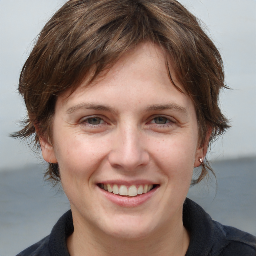

In [ ]:
from tensorflow.keras.preprocessing.image import load_img
print(f"Label associated to the 30-th sample: {float(df.loc[df['id'] == 30]['glasses'])}.\nHowever, the 30-th image is clearly a person with no glasses.\n")
load_img("faces-spring-2020/faces-spring-2020/face-30.png", target_size=(256, 256))

Label associated to the 31-th sample: 1.0.
However, the 31-th image is clearly a person with no glasses.



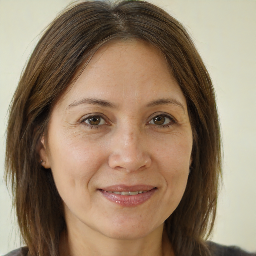

In [ ]:
print(f"Label associated to the 31-th sample: {float(df.loc[df['id'] == 31]['glasses'])}.\nHowever, the 31-th image is clearly a person with no glasses.\n")
load_img("faces-spring-2020/faces-spring-2020/face-31.png", target_size=(256, 256))

While correcting them, we also noticed some images in which stating if the person had glasses or not was hard: this happens because the subjects are created by a Generative Adversarial Neural Network (they are not real people), so there can be some errors. In order to avoid confusion and because we are talking about a small amount of samples, we can drop them without bad consequences.

Examples of images to which assigning a label could be misleading:



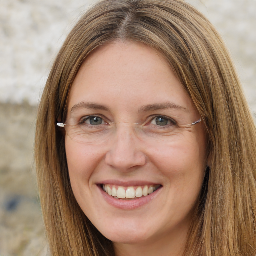

In [ ]:
print("Examples of images to which assigning a label could be misleading:\n")
load_img("faces-spring-2020/faces-spring-2020/face-428.png", target_size=(256, 256))

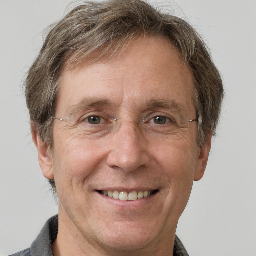

In [ ]:
load_img("faces-spring-2020/faces-spring-2020/face-453.png", target_size=(256, 256))

In the GitHub repository of the project we provide a `.csv` file with all the correct labels associated with the *id* of the images (which are taken by the paths, because every image has a path with a unique number). We download it and replace the old labels column in the dataset. Next, we drop samples with an undefined label.

In [ ]:
correct_labels_path = "https://raw.githubusercontent.com/flaviofuria/GlassesOrNoGlasses/main/labels.csv"
df["glasses"] = pd.read_csv(correct_labels_path)["label"] 

In [ ]:
# delete rows with NaN values
if df.isnull().values.any():
    print(f"{df.isnull().values.ravel().sum()} row(s) with undefined labels in the set have been found and will be removed.")    
    df.dropna(inplace=True)
    df.reset_index(drop=True, inplace=True)
df

21 row(s) with undefined labels in the set have been found and will be removed.


id       v1       v2       v3  ...     v510     v511     v512  glasses
0        1  0.37797 -0.94808  0.01346  ...  1.08635  1.69027  0.61609      0.0
1        2  0.07609 -0.09774  0.39666  ...  0.00866 -1.27640 -0.60496      1.0
2        3  1.19391 -0.68707 -0.68422  ... -0.60177  0.43555  0.41982      1.0
3        4  1.34949 -0.31498 -1.30248  ...  0.83997 -0.46986  0.06755      0.0
4        5 -0.03512 -0.34196  0.14230  ...  0.83641  0.59756 -0.20298      0.0
...    ...      ...      ...      ...  ...      ...      ...      ...      ...
4974  4996  0.07877 -0.47999  0.26438  ... -0.43146  0.26931 -0.84718      1.0
4975  4997  1.93614  0.55157 -1.50441  ...  0.02158 -0.48717 -0.34507      1.0
4976  4998  0.08998 -0.33035  0.15433  ... -1.32600 -0.16452 -0.20689      1.0
4977  4999 -1.00379  0.15693  0.25717  ...  0.08115  1.23236  0.42304      0.0
4978  5000 -0.18730 -0.91576  0.32625  ...  1.03222 -1.12067 -1.10786      1.0

[4979 rows x 514 columns]

<h1>Classes balancing</h1>

Now we look at the balance between the two classes, in order to decide if we should go for some under/oversampling.<br>Fortunately, the dataset is pretty well balanced, so we don't need to apply any sort of rebalancing.

2784 Glasses
2195 No Glasses


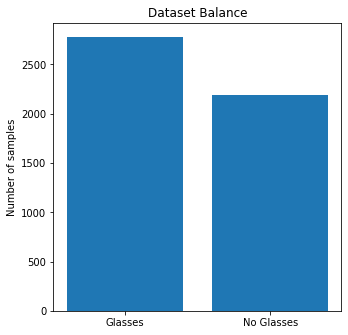

In [ ]:
ones, zeros = df["glasses"].value_counts()
print(f"{ones} Glasses\n{zeros} No Glasses")
x_labels, x_values = ["Glasses", "No Glasses"], [ones, zeros]

import matplotlib.pyplot as plt
fig = plt.figure(figsize=(4,4))
ax = fig.add_axes([0,0,1,1])
ax.set_ylabel("Number of samples")
ax.set_yticks(np.arange(0, df.shape[0], 500))
ax.bar(x_labels, x_values)
plt.title("Dataset Balance")
plt.show()

<h1>Standardization</h1>

At this time we should apply some standardization: we compute mean and standard deviation for every column/feature and for each value in each column we subtract the mean and divide the result by the standard deviation. In this way, every column/feature will have a mean of 0 and a standard deviation of 1.

In [ ]:
X = df.iloc[:, 1:-1]
Y = np.array(df["glasses"])

means = X.mean()
stds = X.std()
X = np.apply_along_axis(lambda x:(x-means)/stds, 1, X.to_numpy())

pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.DataFrame(X).describe()

0        1        2        3    ...      508      509      510      511
count 4979.000 4979.000 4979.000 4979.000  ... 4979.000 4979.000 4979.000 4979.000
mean     0.000    0.000   -0.000    0.000  ...    0.000    0.000    0.000   -0.000
std      1.000    1.000    1.000    1.000  ...    1.000    1.000    1.000    1.000
min     -3.793   -3.111   -3.401   -3.662  ...   -3.236   -3.292   -3.680   -3.425
25%     -0.676   -0.674   -0.686   -0.690  ...   -0.707   -0.676   -0.642   -0.668
50%     -0.040   -0.035    0.016   -0.043  ...   -0.028   -0.002    0.021   -0.024
75%      0.619    0.647    0.696    0.672  ...    0.675    0.699    0.667    0.650
max      3.228    3.409    4.974    3.774  ...    3.927    3.540    3.134    3.481

[8 rows x 512 columns]

<h1>Data Visualization: PCA and t-SNE</h1>

Next, we apply dimensionality reduction: in general, dimensionality reduction is tool to map a high-dimensional space into a low-dimensional space, hopefully keeping untouched the meaningful properties of the original data, and, at the same time, allowing to have a simplier look at them.
We decide to reduce dimensionality only for visualization (thus we will reduce the dimensions from 512 to 2), using two techniques:
<ul>
  <li>Principal Component Analysis, a linear transformation that aims to map dissimilar points into distant low-dimensional representation.</li>
  <li>t-Distributed Stochastic Neighbor Embedding, that is non-linear and, in addition, tries to keep similar points closer in the low-dimensional representation. Being non-linear, it is harder to compute and, thus, often leads to better results.</li>
</ul>


In [ ]:
n_components = 2      # we only want to visualize data in a lower dimensional space, so we keep two dimensions

In [ ]:
from matplotlib.colors import ListedColormap

def dim_reduction_plot(first_dimension:np.array, second_dimension:np.array, labels:np.array, title=str):
  fig = plt.figure(figsize=(8,8))
  plt.title(title)
  colors = ListedColormap(["blue", "orange"])
  scatter = plt.scatter(first_dimension, second_dimension, alpha=0.5, c=labels, cmap=colors)
  plt.legend(handles=scatter.legend_elements()[0], labels=["Glasses", "No Glasses"])
  plt.show()

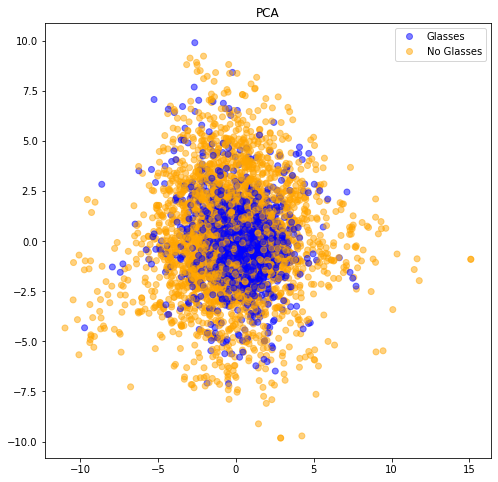

In [ ]:
from sklearn.decomposition import PCA
pca_X = PCA(n_components=n_components, random_state=random_state).fit_transform(X)
if n_components == 2:
  dim_reduction_plot(pca_X[:, 0], pca_X[:, 1], Y, "PCA")

PCA does show something: we can see that samples corresponding to people with glasses are grouped around the center but, this representation suggests us that a non-linear transformation could tell us something more.

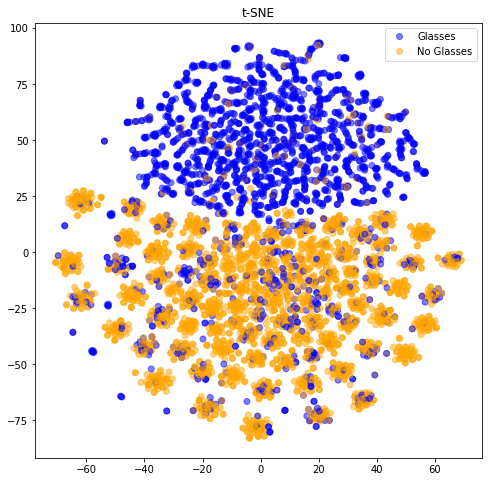

In [ ]:
from sklearn.manifold import TSNE
tsne_X = TSNE(n_components=n_components, perplexity=30, init="pca", random_state=random_state, method="barnes_hut", n_jobs=-1).fit_transform(X)
if n_components == 2:
  dim_reduction_plot(tsne_X[:, 0], tsne_X[:, 1], Y, "t-SNE")

t-SNE (thus, non-linearity) works definitely better: there is a clear line that separates the majority of positive and negative samples. This means that there is a correlation between data and labels and we hope to capture it with neural networks.

**<h1>Multi-Layer Perceptron</h1>**
<h1>Train/Test split</h1>

The first thing we do now is a train/test split with a ratio of 0.8/0.2. We skip the creation of a validation set for the moment, because we will apply *k-fold cross-validation*.

In [ ]:
test_size = 0.2

from sklearn.model_selection import train_test_split
X_train_val, X_test, Y_train_val, Y_test = train_test_split(X, Y, test_size=test_size, random_state=random_state)

print(f"Training set:   {X_train_val.shape}")
print(f"Test set:        {X_test.shape}")

Training set:   (3983, 512)
Test set:        (996, 512)


In [ ]:
# This creates the models
from tensorflow.keras.models import Sequential
def build_model(layers_list:list, optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"]) -> Sequential:
    model = Sequential()    
    for l in layers_list:
        model.add(l)
    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)  
    return model

In [ ]:
# This allows to plot accuracy and loss for every trained model
def plot_results(metrics:(), metric_name:str):
  plt.plot(metrics[0])
  plt.plot(metrics[1])
  plt.title("Model " + metric_name)
  plt.ylabel(metric_name)
  plt.xlabel("epoch")
  plt.legend(["train", "val"], loc="upper left")
  plt.show()


def plot_and_print(hist, test_loss, test_accuracy, index):
  plot_results((hist.history["accuracy"], hist.history["val_accuracy"]), "accuracy")
  plot_results((hist.history["loss"], hist.history["val_loss"]), "loss")
  print(f"\nTraining Loss:        {round(hist.history['loss'][index], 4)}")
  print(f"Training Accuracy:    {round(hist.history['accuracy'][index], 4)}")
  print(f"\nValidation Loss:      {round(hist.history['val_loss'][index], 4)}")
  print(f"Validation Accuracy:  {round(hist.history['val_accuracy'][index], 4)}")
  print(f"\nTest Loss:            {round(test_loss, 4)}")
  print(f"Test Accuracy:        {round(test_accuracy, 4)}")    

<h1>First try</h1>

We are facing a binary classification problem. Thus, we use `sigmoid` as function for our output neuron and `binary crossentropy` as loss function. We try a simple model with just one hidden layer of 16 `neurons` and one of 8 `neurons`, both with `relu` activation functions, a `batch size` of 128 and 50 `epochs`. Probably the model will stop before going through all of them, because we also opt for an `early stopping` if the `validation loss` stops to decrease. We use `Adam` with a `learning rate` of 0.001 as the `optimizer`. We will use the 20% of the training set as validation set.

In [ ]:
!mkdir model_weights

In [ ]:
epochs = 50
batch_size = 128

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
early_stopping = EarlyStopping(monitor="val_loss", patience=5)
checkpoint = ModelCheckpoint(filepath="model_weights/first_try.hdf5", monitor="val_loss", verbose=0, save_best_only=True, save_weights_only=True)

num_features = X_train_val.shape[1]
val_split = 0.2

In [ ]:
from tensorflow.keras.layers import Dense
layers_list = [Dense(16, activation="relu", input_shape=(num_features,)),
               Dense(8, activation="relu"),
               Dense(1, activation="sigmoid")]

first_model = build_model(layers_list)
first_history = first_model.fit(x=X_train_val, y=Y_train_val, epochs=epochs, batch_size=batch_size, shuffle=True, validation_split=val_split, verbose=0, callbacks=[early_stopping, checkpoint])

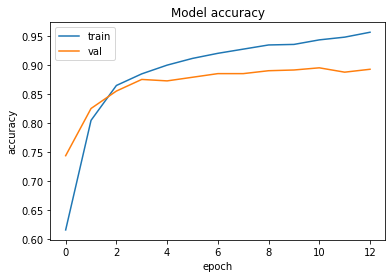

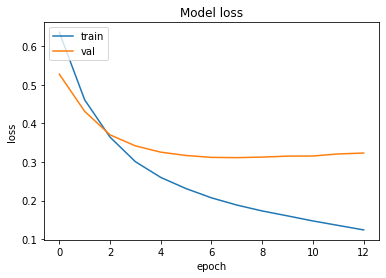


Training Loss:        0.1885
Training Accuracy:    0.9281

Validation Loss:      0.3113
Validation Accuracy:  0.8858

Test Loss:            0.309
Test Accuracy:        0.8624


In [ ]:
first_model.load_weights("model_weights/first_try.hdf5")
first_test_loss, first_test_accuracy = first_model.evaluate(X_test, Y_test, batch_size, verbose=0)

best_epoch_index = np.argmin(first_history.history["val_loss"])
plot_and_print(first_history, first_test_loss, first_test_accuracy, best_epoch_index)

These two plots clearly show us that our predictor starts overfitting after just few epochs. In fact, after ten epochs the validation loss starts increasing, so the training stops. The number of parameters is way too high with respect to the number of samples, so we can try to apply `dropout`, hoping that "switching off" some neurons (thus, reducing parameters), will bring overfitting down.

<h1>Second try (with Dropout)</h1>

As we have just said, adding units or layers would make the network overfit even more; thus, we try a model with the same architecture of the last one, but we switch off the 40% of the neurons between the first and the second layer. To be more precise, we give every neuron a probability of 0.4 to be omitted during training.

In [ ]:
early_stopping = EarlyStopping(monitor="val_loss", patience=10)     # 200 epochs are probably be too much, so we stop when validation loss stops decreasing
checkpoint = ModelCheckpoint(filepath="model_weights/second_try.hdf5", monitor="val_loss", verbose=0, save_best_only=True, save_weights_only=True)

from tensorflow.keras.layers import Dropout
layers_list = [Dense(16, activation="relu", input_shape=(num_features,)),
               Dropout(0.4),
               Dense(8, activation="relu"),
               Dense(1, activation="sigmoid")]

second_model = build_model(layers_list)
second_history = second_model.fit(x=X_train_val, y=Y_train_val, epochs=epochs, batch_size=batch_size, shuffle=True, validation_split=val_split, verbose=0, callbacks=[early_stopping, checkpoint])

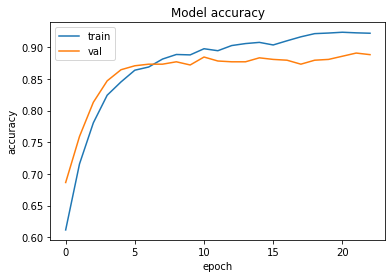

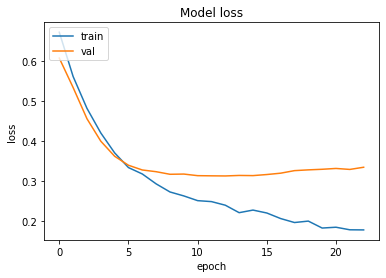


Training Loss:        0.2397
Training Accuracy:    0.9027

Validation Loss:      0.3128
Validation Accuracy:  0.877

Test Loss:            0.2953
Test Accuracy:        0.8765


In [ ]:
second_model.load_weights("model_weights/second_try.hdf5")
second_test_loss, second_test_accuracy = second_model.evaluate(X_test, Y_test, batch_size, verbose=0)

best_epoch_index = np.argmin(second_history.history["val_loss"])
plot_and_print(second_history, second_test_loss, second_test_accuracy, best_epoch_index)

As expected, overfitting is still here, but at least we have lowered it in some way. As a result, the scores for the training set are slightly worse but those for the validation/test set are slightly better. Can we do even better? 

<h1>Third try (with regularizers and lower learning rate)</h1>

We add some units with some more dropout probability and use two regularization parameters, `l1` and `l2`, which both decrease the weights of the neurons.
Other than that, we lower the initial (it will be automatically adapted during the training, according to the Adam implementation) default learning rate for the Adam optimizer from `1e-3` to `1e-4`: this means that the overall training process will be slower but hopefully the gradient descent will converge to the global minimum.

In [ ]:
epochs = 200                                                        # we increase the number of epochs because a lower learning rate slows the training process down
batch_size = 128
early_stopping = EarlyStopping(monitor="val_loss", patience=10)     # 200 epochs are probably be too much, so we stop when validation loss stops decreasing
checkpoint = ModelCheckpoint(filepath="model_weights/third_try.hdf5", monitor="val_loss", verbose=0, save_best_only=True, save_weights_only=True)

from tensorflow.keras.optimizers import Adam
optimizer = Adam(1e-4)

from tensorflow.keras import regularizers
layers_list = [Dense(32, activation="relu", input_shape=(num_features,)),
               Dropout(0.5),
               Dense(16, activation="relu", kernel_regularizer=regularizers.l1_l2(l1=.00001, l2=.00001)),
               Dropout(0.5),
               Dense(1, activation="sigmoid")]

third_model = build_model(layers_list, optimizer=optimizer)
third_history = third_model.fit(x=X_train_val, y=Y_train_val, epochs=epochs, batch_size=batch_size, shuffle=True, validation_split=val_split, verbose=0, callbacks=[early_stopping, checkpoint])

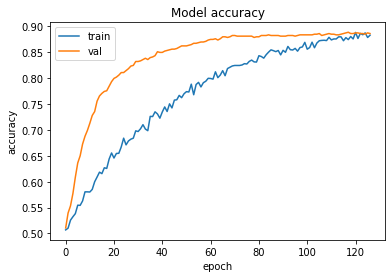

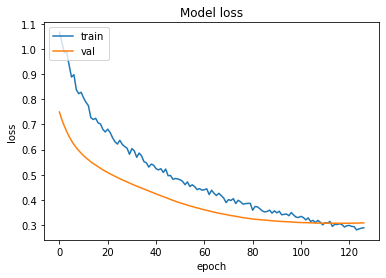


Training Loss:        0.3047
Training Accuracy:    0.8779

Validation Loss:      0.3064
Validation Accuracy:  0.8871

Test Loss:            0.298
Test Accuracy:        0.8725


In [ ]:
third_model.load_weights("model_weights/third_try.hdf5")
third_test_loss, third_test_accuracy = third_model.evaluate(X_test, Y_test, batch_size, verbose=0)

best_epoch_index = np.argmin(third_history.history["val_loss"])
plot_and_print(third_history, third_test_loss, third_test_accuracy, best_epoch_index)

Probably, we can't do much more: overfitting has almost disappeared and validation/test loss slightly have decreased. In order to check if our reasoning is correct, we can try one more thing.

<h1>Bayesian Optimization</h1>

There could be a better choice of architecture and hyperparameters: we will found out if it's true thanks to `Bayesian Optimization`, a tool that given an hyperparameter search space, finds the best combination of them in order to minimize the `validation loss`.Since it easy quite computationally expensive, if we want to decrease the execution time we should lower the values of `max_trials` and `executions_per_trial`. We use the implementation provided in the `keras-tuner` framework ([github.com/keras-team/keras-tuner](https://))

In [ ]:
# install the framework
!pip install -q keras_tuner

     |████████████████████████████████| 97 kB 3.1 MB/s 


We first define a function that will build our model, giving a range of hyperparameters that will form the search space for the optimization tool.

In [ ]:
def bayesian_opt_model(hp):
  model = Sequential()
  model.add(Dense(units=hp.Int("units_0", 8, 256, 16), activation=hp.Choice("activation_0", ["relu", "sigmoid", "tanh"]), input_shape=(num_features,)))
  if hp.Boolean(name='dropout_0'):
    model.add(Dropout(rate=hp.Choice("rate_0", [0e-1, 1e-1, 2e-1, 3e-1, 4e-1, 5e-1, 6e-1, 7e-1, 8e-1, 9e-1])))
  for i in range(hp.Int("num_layers", 1, 6)):
    model.add(Dense(units=hp.Int("units_"+str(i), 8, 256, 16),
                    kernel_regularizer=regularizers.l1_l2(l1=hp.Choice("l1_"+str(i), [0e-1, 1e-1, 1e-2, 1e-3, 1e-4, 1e-5]), l2=hp.Choice("l2_"+str(i), [0e-1, 1e-1, 1e-2, 1e-3, 1e-4, 1e-5])),
                    activation=hp.Choice("activation_"+str(i), ["relu", "sigmoid", "tanh"])))
    if hp.Boolean(name='dropout_'+str(i)):
      model.add(Dropout(rate=hp.Choice("rate_"+str(i), [0e-1, 1e-1, 2e-1, 3e-1, 4e-1, 5e-1, 6e-1, 7e-1, 8e-1, 9e-1])))
  model.add(Dense(1, activation="sigmoid"))    
  model.compile(optimizer=Adam(learning_rate=hp.Choice("learning_rate", [1e-1, 1e-2, 1e-3, 1e-4, 1e-5]),
                               beta_1=hp.Choice("beta_1", [6e-1, 7e-1, 8e-1, 9e-1]),
                               beta_2=hp.Choice("beta_2", [9.85e-1, 9.90e-1, 9.95e-1, 9.99e-1]), amsgrad=hp.Boolean("amsgrad")), loss="binary_crossentropy", metrics=["accuracy"])
  return model

We create the model and search for the best hyperparameters combination.

In [ ]:
!rm -r /content/glasses/*     # if you want to delete experiments made by keras-tuner

rm: cannot remove '/content/glasses/*': No such file or directory


In [ ]:
max_trials = 10
executions_per_trial = 5

from keras_tuner import BayesianOptimization
tuner = BayesianOptimization(bayesian_opt_model, objective="val_loss", max_trials=max_trials, executions_per_trial=executions_per_trial, seed=random_state, project_name="glasses")
tuner.search(X_train_val, Y_train_val, epochs=epochs, batch_size=batch_size, validation_split=val_split, shuffle=True, verbose=1, callbacks=[EarlyStopping(monitor="val_loss", patience=10)])

Trial 10 Complete [00h 01m 22s]
val_loss: 0.31459922790527345

Best val_loss So Far: 0.2992721915245056
Total elapsed time: 00h 09m 50s
INFO:tensorflow:Oracle triggered exit


We need one last step in order to be sure that our model is reliable.

<h1>Applying k-Fold Cross-Validation (on the best model according to RandomSearch)</h1>

We use the best combination of hyperparameters found thanks to Bayesian Optimization to create a brand new model and apply `k-Fold Cross-Validation`, a technique that consists in dividing the training set in *k* subsets/folds and then train the model *k* times: each time we use one different fold for validation and the other *k-1* for training. At each step we can also use our test set (which still has to remain unseen to the model) to evaluate the predictions. In the end we take the average of all the produced scores in order to check if the model performs well even when receiving different combinations of train/validation sets.

In [ ]:
# This creates the folds as defined in k-fold cross validation
def k_fold(size:int, k:int) -> list:
  indices = np.array(range(size))
  np.random.shuffle(indices)
  splits = np.array_split(indices, k, axis=0)
  folds = []
  for i in range(k):
    #folds.append((np.delete(indices, splits[i]), splits[i]))
    folds.append((np.array([j for j in indices if j not in splits[i]]), splits[i]))
  return folds

In [ ]:
k = 5           # number of folds
verbose = 0     # if 1, training info will be shown and each fold will be plotted
folds_results = {"accuracy":[], "val_accuracy":[], "test_accuracy":[], "loss":[], "val_loss":[], "test_loss":[]}

for j, fold in enumerate(k_fold(X_train_val.shape[0], k)):
  X_train, X_val = X_train_val[fold[0]], X_train_val[fold[1]]
  Y_train, Y_val = Y_train_val[fold[0]], Y_train_val[fold[1]]

  tf.keras.backend.clear_session()
  best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]
  model = tuner.hypermodel.build(best_hyperparameters)

  if j==0:
    print(model.summary())
    print(f"\nOptimizer {model.optimizer.get_config()['name']} with learning rate: {model.optimizer.get_config()['learning_rate']}\n\n")

  early_stopping = EarlyStopping(monitor="val_loss", patience=10)
  checkpoint = ModelCheckpoint(filepath="model_weights/"+str(j)+"th_fold_numerical.hdf5", monitor="val_loss", verbose=0, save_best_only=True, save_weights_only=True)
  history = model.fit(x=X_train, y=Y_train, epochs=epochs, batch_size=batch_size, shuffle=True, validation_data=(X_val, Y_val), verbose=verbose, callbacks=[early_stopping, checkpoint])   

  best_epoch_index = np.argmin(history.history["val_loss"])
  folds_results["accuracy"].append(history.history["accuracy"][best_epoch_index])
  folds_results["val_accuracy"].append(history.history["val_accuracy"][best_epoch_index])
  folds_results["loss"].append(history.history["loss"][best_epoch_index])
  folds_results["val_loss"].append(history.history["val_loss"][best_epoch_index])

  model.load_weights("model_weights/"+str(j)+"th_fold_numerical.hdf5")
  test_loss, test_accuracy = model.evaluate(X_test, Y_test, batch_size=batch_size, verbose=0)
  folds_results["test_accuracy"].append(test_accuracy)
  folds_results["test_loss"].append(test_loss)

  if verbose:
      print(f"\n{j+1}-th FOLD OUT OF {k}\n")
      plot_results((history.history["accuracy"], history.history["val_accuracy"]), "accuracy")
      plot_results((history.history["loss"], history.history["val_loss"]), "loss")

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 4104      
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 72        
_________________________________________________________________
dense_2 (Dense)              (None, 152)               1368      
_________________________________________________________________
dropout (Dropout)            (None, 152)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 153       
Total params: 5,697
Trainable params: 5,697
Non-trainable params: 0
_________________________________________________________________
None

Optimizer Adam with learning rate: 0.001




In [ ]:
print(f"\nAvg Training Loss:        {round(sum(folds_results['loss'])/k, 5)}")
print(f"Avg Training Accuracy:    {round(sum(folds_results['accuracy'])/k, 5)}")
print(f"\nAvg Validation Loss:      {round(sum(folds_results['val_loss'])/k, 5)}")
print(f"Avg Validation Accuracy:  {round(sum(folds_results['val_accuracy'])/k, 5)}")
print(f"\nAvg Test Loss:            {round(sum(folds_results['test_loss'])/k, 5)}")
print(f"Avg Test Accuracy:        {round(sum(folds_results['test_accuracy'])/k, 5)}")


Avg Training Loss:        0.22578
Avg Training Accuracy:    0.91363

Avg Validation Loss:      0.30383
Avg Validation Accuracy:  0.88401

Avg Test Loss:            0.30052
Avg Test Accuracy:        0.87892


Sadly the test loss is slightly higher than the training and the validation ones. We think that there is no great room for improvements; thus, we move to images, with the idea that they will lead to definitely better results.

**<h1>Images</h1>**

As already said, this dataset is made up of *1024x1024* RGB images of (not real) people wearing or not wearing glasses.

Example of person wearing glasses.


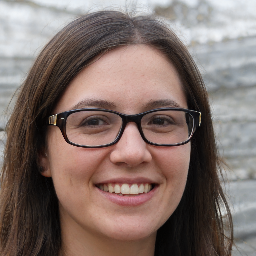

In [ ]:
print("Example of person wearing glasses.")
load_img("faces-spring-2020/faces-spring-2020/face-15.png", target_size=(256, 256))

Example of person not wearing glasses.


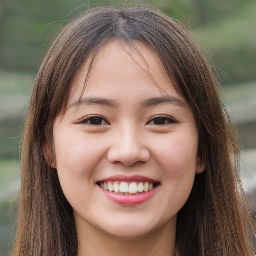

In [ ]:
print("Example of person not wearing glasses.")
load_img("faces-spring-2020/faces-spring-2020/face-13.png", target_size=(256, 256))

<h1>Importing the data</h1>

The images have already been downloaded in the beginning of this notebook. We import them using `load_img`, a function provided in `tf.keras.preprocessing.image` module. For matter of space and time complexity, we fix the size of images to be` 128x128x3` (one pixel is made up of 3 values, one for each of the RGB channels): we think that this size will be enough to guarantee good results. We turn every image to a `Numpy array` and use the same array of labels we used for numerical data, dropping samples with undefined labels, as we have already shown earlier.

In [ ]:
imgs_num = 5000
height, width = 128, 128
imgs_matrices = np.empty(shape=(imgs_num), dtype=np.ndarray)

from tensorflow.keras.preprocessing.image import img_to_array
for i in range(imgs_num):
  path = "faces-spring-2020/faces-spring-2020/face-" + str(i+1) + ".png"
  img = load_img(path, target_size=(height, width))
  img_array = img_to_array(img)
  imgs_matrices[i] = img_array

X = np.array(imgs_matrices.tolist())
Y = np.array(pd.read_csv(correct_labels_path)["label"])

nans = []
for index, y in enumerate(Y):
  if y!=1 and y!=0:
    nans.append(index)

X = np.delete(X, nans, axis=0)
Y = np.delete(Y, nans)

In order to have values ranging from 0 to 1, we normalize each pixel value of each sample, dividing it by *255*. 

In [ ]:
# normalization
X = X / 255.0
X.shape

(4979, 128, 128, 3)

**<h1>Convolutional Neural Network</h1>**
<h1>Train/Test split</h1>

As we did before, we proceed with a 0.8/0.2 train/test split.

In [ ]:
test_size = 0.2

X_train_val, X_test, Y_train_val, Y_test = train_test_split(X, Y, test_size=test_size, random_state=random_state)

print(f"Training set:   {X_train_val.shape}")
print(f"Test set:        {X_test.shape}")

Training set:   (3983, 128, 128, 3)
Test set:        (996, 128, 128, 3)


<h1>Training the Model</h1>

We opt for a quite simple CNN with two convolutional layers with kernels of size *3x3*, each one followed by a max pooling layers and, after the flatten layer, two dense layers with 32 and 16 units respectively.

In [ ]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten
layers_list = [Conv2D(kernel_size=3, filters=16, activation="relu", input_shape=(height, width, 3)),
               MaxPooling2D(strides=2),
               Conv2D(kernel_size=5, filters=32, activation="relu"),
               MaxPooling2D(strides=2),
               Flatten(),
               Dense(32, activation="relu"),
               Dense(16, activation="relu"),
               Dense(1, activation="sigmoid")]

We will probably need a less number of epochs to train our model: we set the number of epochs to 30 that won't be reached if the validation loss starts increasing. As usual, we will save the weights of the best epoch, according to validation loss, and use them to evaluate the model.

In [ ]:
epochs = 10
batch_size = 64
early_stopping = EarlyStopping(monitor="val_accuracy", patience=3)
checkpoint = ModelCheckpoint(filepath="model_weights/first_try_images.hdf5", monitor="val_accuracy", verbose=0, save_best_only=True, save_weights_only=True)

model = build_model(layers_list)
history = model.fit(x=X_train_val, y=Y_train_val, epochs=epochs, batch_size=batch_size, shuffle=True, validation_split=val_split, verbose=1, callbacks=[early_stopping, checkpoint])

Epoch 1/10
50/50 [==============================] - 54s 1s/step - loss: 0.4309 - accuracy: 0.7787 - val_loss: 0.1391 - val_accuracy: 0.9486
Epoch 2/10
50/50 [==============================] - 53s 1s/step - loss: 0.0574 - accuracy: 0.9846 - val_loss: 0.0425 - val_accuracy: 0.9887
Epoch 3/10
50/50 [==============================] - 53s 1s/step - loss: 0.0359 - accuracy: 0.9915 - val_loss: 0.0730 - val_accuracy: 0.9787
Epoch 4/10
50/50 [==============================] - 53s 1s/step - loss: 0.0296 - accuracy: 0.9934 - val_loss: 0.0379 - val_accuracy: 0.9950
Epoch 5/10
50/50 [==============================] - 53s 1s/step - loss: 0.0202 - accuracy: 0.9956 - val_loss: 0.0332 - val_accuracy: 0.9900
Epoch 6/10
50/50 [==============================] - 53s 1s/step - loss: 0.0177 - accuracy: 0.9959 - val_loss: 0.0361 - val_accuracy: 0.9937
Epoch 7/10
50/50 [==============================] - 53s 1s/step - loss: 0.0194 - accuracy: 0.9959 - val_loss: 0.0473 - val_accuracy: 0.9862


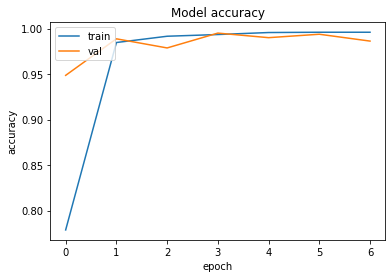

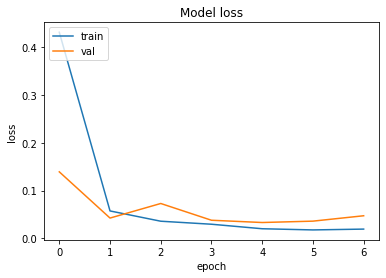


Training Loss:        0.0202
Training Accuracy:    0.9956

Validation Loss:      0.0332
Validation Accuracy:  0.99

Test Loss:            0.0305
Test Accuracy:        0.992


In [ ]:
model.load_weights("model_weights/first_try_images.hdf5")
test_loss, test_accuracy = model.evaluate(X_test, Y_test, batch_size, verbose=0)

best_epoch_index = np.argmin(history.history["val_loss"])
plot_and_print(history, test_loss, test_accuracy, best_epoch_index)

The results are **way** better than what we had with the other dataset: there is no overfitting, we have an accuracy of *0.99* even for the test set. We don't even need to try other architectures, we can just apply k-Fold Cross-Validation to be sure that it was not just a lucky shot.

<h1>Applying k-Fold Cross-Validation</h1>

Epoch 1/10
42/42 [==============================] - 48s 1s/step - loss: 0.0435 - accuracy: 0.9906 - val_loss: 0.0243 - val_accuracy: 0.9947
Epoch 2/10
42/42 [==============================] - 47s 1s/step - loss: 0.0226 - accuracy: 0.9947 - val_loss: 0.0197 - val_accuracy: 0.9962
Epoch 3/10
42/42 [==============================] - 47s 1s/step - loss: 0.0166 - accuracy: 0.9977 - val_loss: 0.0218 - val_accuracy: 0.9955
Epoch 4/10
42/42 [==============================] - 47s 1s/step - loss: 0.0124 - accuracy: 0.9981 - val_loss: 0.0193 - val_accuracy: 0.9962
Epoch 5/10
42/42 [==============================] - 47s 1s/step - loss: 0.0145 - accuracy: 0.9962 - val_loss: 0.0172 - val_accuracy: 0.9955

1-th FOLD OUT OF 3



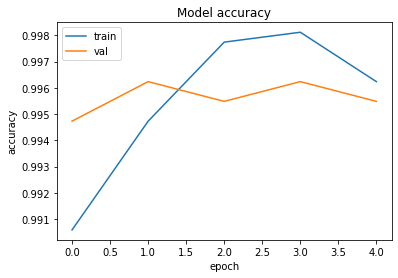

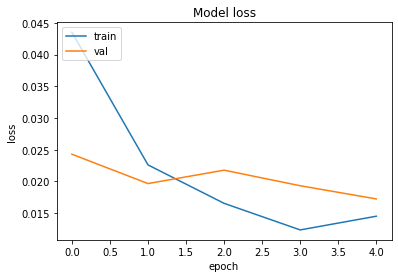

Epoch 1/10
42/42 [==============================] - 47s 1s/step - loss: 0.0226 - accuracy: 0.9936 - val_loss: 0.0428 - val_accuracy: 0.9910
Epoch 2/10
42/42 [==============================] - 47s 1s/step - loss: 0.0177 - accuracy: 0.9959 - val_loss: 0.0212 - val_accuracy: 0.9940
Epoch 3/10
42/42 [==============================] - 47s 1s/step - loss: 0.0095 - accuracy: 0.9977 - val_loss: 0.0105 - val_accuracy: 0.9977
Epoch 4/10
42/42 [==============================] - 47s 1s/step - loss: 0.0058 - accuracy: 0.9992 - val_loss: 0.0135 - val_accuracy: 0.9970
Epoch 5/10
42/42 [==============================] - 47s 1s/step - loss: 0.0044 - accuracy: 0.9985 - val_loss: 0.0144 - val_accuracy: 0.9962
Epoch 6/10
42/42 [==============================] - 47s 1s/step - loss: 0.0026 - accuracy: 0.9992 - val_loss: 0.0177 - val_accuracy: 0.9947

2-th FOLD OUT OF 3



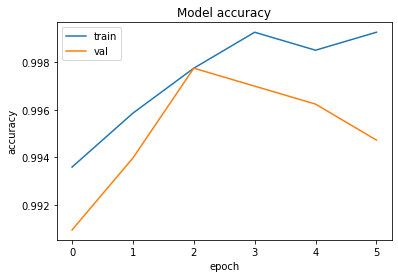

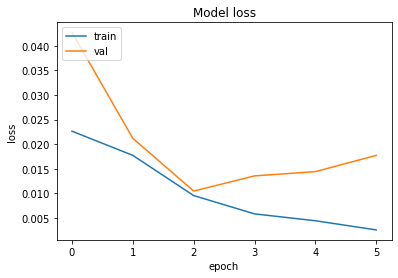

Epoch 1/10
42/42 [==============================] - 48s 1s/step - loss: 0.0141 - accuracy: 0.9959 - val_loss: 0.0159 - val_accuracy: 0.9962
Epoch 2/10
42/42 [==============================] - 47s 1s/step - loss: 0.0068 - accuracy: 0.9985 - val_loss: 0.0053 - val_accuracy: 0.9992
Epoch 3/10
42/42 [==============================] - 47s 1s/step - loss: 0.0039 - accuracy: 0.9992 - val_loss: 0.0089 - val_accuracy: 0.9985
Epoch 4/10
42/42 [==============================] - 47s 1s/step - loss: 0.0044 - accuracy: 0.9985 - val_loss: 0.0066 - val_accuracy: 0.9977
Epoch 5/10
42/42 [==============================] - 47s 1s/step - loss: 0.0035 - accuracy: 0.9992 - val_loss: 0.0063 - val_accuracy: 0.9992

3-th FOLD OUT OF 3



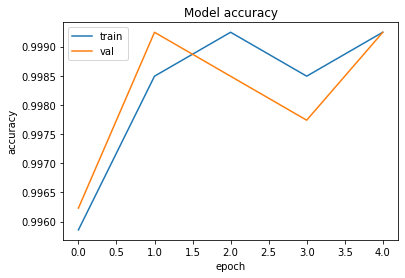

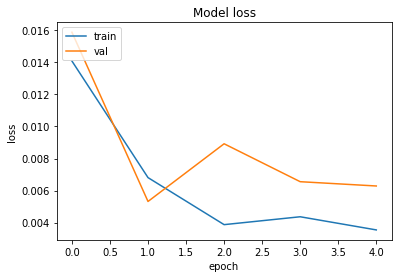

In [ ]:
k = 3          # number of folds, we choose 3 because cnns take a lot of time to train
verbose = 1    # if 1, training info will be shown and each fold will be plotted
folds_results = {"accuracy":[], "val_accuracy":[], "test_accuracy":[], "loss":[], "val_loss":[], "test_loss":[]}

for j, fold in enumerate(k_fold(X_train_val.shape[0], k)):      
  X_train, X_val = X_train_val[fold[0]], X_train_val[fold[1]]
  Y_train, Y_val = Y_train_val[fold[0]], Y_train_val[fold[1]]

  checkpoint = ModelCheckpoint(filepath="model_weights/"+str(j)+"th-fold_images.hdf5", monitor="val_loss", verbose=0, save_best_only=True, save_weights_only=True)
  if verbose:
    print(f"\n{j+1}-th FOLD OUT OF {k}\n")
  model = build_model(layers_list)
  history = model.fit(x=X_train, y=Y_train, epochs=epochs, batch_size=batch_size, shuffle=True, validation_data=(X_val, Y_val), verbose=verbose, callbacks=[early_stopping, checkpoint])

  best_epoch_index = np.argmin(history.history["val_loss"])
  folds_results["accuracy"].append(history.history["accuracy"][best_epoch_index])
  folds_results["val_accuracy"].append(history.history["val_accuracy"][best_epoch_index])
  folds_results["loss"].append(history.history["loss"][best_epoch_index])
  folds_results["val_loss"].append(history.history["val_loss"][best_epoch_index])

  model.load_weights("model_weights/"+str(j)+"th-fold_images.hdf5")
  test_loss, test_accuracy = model.evaluate(X_test, Y_test, batch_size=batch_size, verbose=0)
  folds_results["test_accuracy"].append(test_accuracy)
  folds_results["test_loss"].append(test_loss)

  if verbose:
      plot_results((history.history["accuracy"], history.history["val_accuracy"]), "accuracy")
      plot_results((history.history["loss"], history.history["val_loss"]), "loss")      

In [ ]:
print(f"\nAvg Training Loss:        {round(sum(folds_results['loss'])/k, 5)}")
print(f"Avg Training Accuracy:    {round(sum(folds_results['accuracy'])/k, 5)}")
print(f"\nAvg Validation Loss:      {round(sum(folds_results['val_loss'])/k, 5)}")
print(f"Avg Validation Accuracy:  {round(sum(folds_results['val_accuracy'])/k, 5)}")
print(f"\nAvg Test Loss:            {round(sum(folds_results['test_loss'])/k, 5)}")
print(f"Avg Test Accuracy:        {round(sum(folds_results['test_accuracy'])/k, 5)}")


Avg Training Loss:        0.01029
Avg Training Accuracy:    0.99749

Avg Validation Loss:      0.01101
Avg Validation Accuracy:  0.99749

Avg Test Loss:            0.02535
Avg Test Accuracy:        0.99297


We are not much surprised to see that the results are great even when averaged among all the folds. 

<h1>Predictions</h1>

Our predictor is so accurate that we can make a last pass on the entire dataset and see all the samples that are misclassified.

In [ ]:
Y = np.array(pd.read_csv(correct_labels_path)["label"])
errors = []
for i, img in enumerate(imgs_matrices):
  if Y[i] != (1.0 if model.predict(np.array([img/255.0]), batch_size=batch_size, workers=-1)[0][0]>=0.5 else 0.0) and (Y[i] == 1.0 or Y[i] == 0.0):
    errors.append(i)

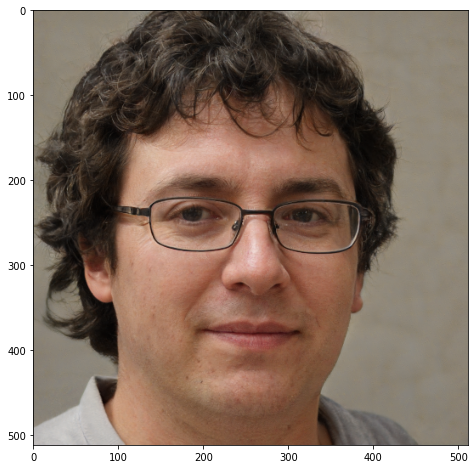

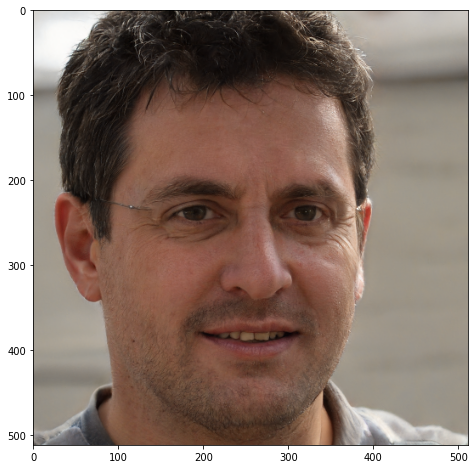

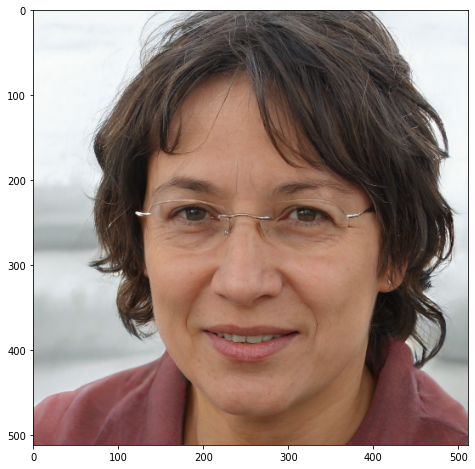

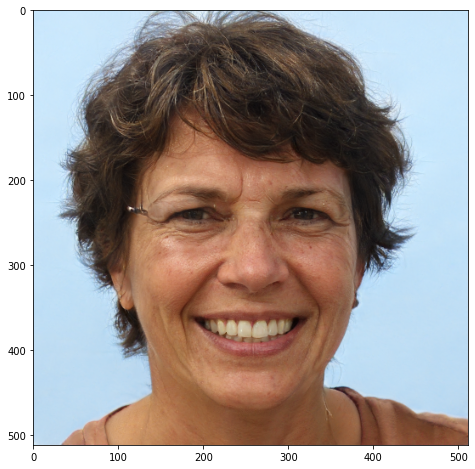

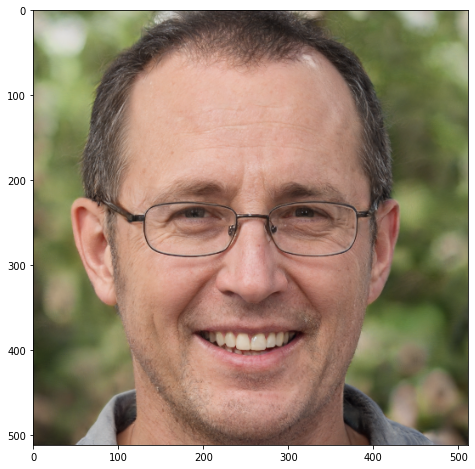

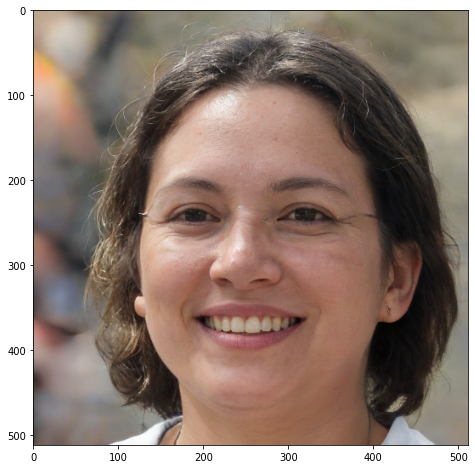

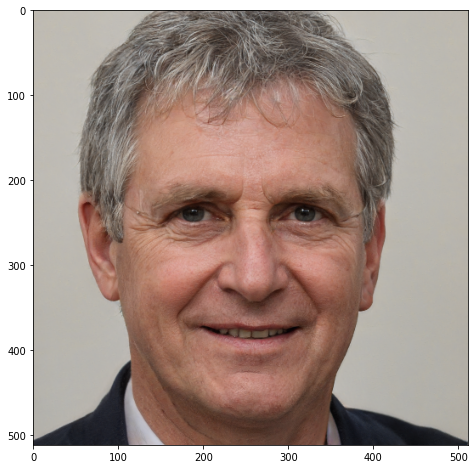

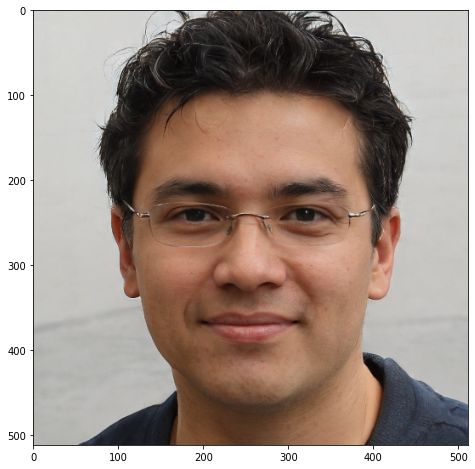

In [48]:
for i in errors:
  plt.figure(figsize=(8, 8))
  plt.imshow(load_img("faces-spring-2020/faces-spring-2020/face-"+str(i+1)+".png", target_size=(512, 512)))

The majority of the errors made by the predictor are easy to justify: they're samples that we should have dropped from the dataset from having an undefined label. Some of the others, instead, are parte of that samples that had a wrong label (and we didn't see when we corrected them).